In [2]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

n_mixtures = 3
hidden_size = 900
input_size = 3
batch_size = 256
n_epochs = 1000
max_length = 1200
lr = 0.00001
model_name = "20210809_Prediction-1LSTM-3Mixtures-900Hidden-256Batch"


cuda:0


In [3]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [4]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [5]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [6]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [7]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [8]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

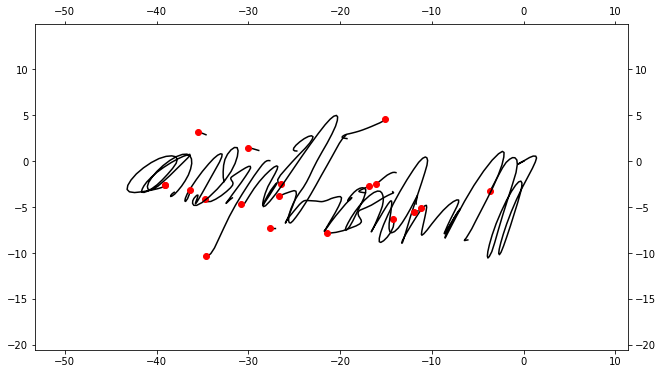

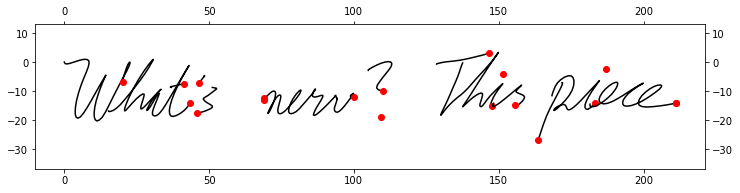

What 's new? This piece


In [9]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [10]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        #self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx] #, self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


In [11]:
class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmLayer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(input_size+hidden_size, output_size)
        
    def forward(self, packed_input, h0, c0):
        packed_out1, (hn, cn) = self.lstmLayer(packed_input, (h0, c0))
        
        lin_layer_input = torch.cat(
            (packed_input.data, packed_out1.data), dim=-1)
        return self.linearLayer(lin_layer_input), (hn, cn)

In [12]:
def get_mixture_params_from_output(outputs):
    pis = nn.Softmax(1)(outputs[:,:n_mixtures])
    mus = outputs[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    
    sigmas = torch.exp(outputs[:, 3*n_mixtures:5*n_mixtures]).reshape(-1, n_mixtures, 2)
    phos = torch.tanh(outputs[:, 5*n_mixtures:6*n_mixtures]).reshape(-1, n_mixtures, 1)
    
    covs = torch.zeros(outputs.shape[0], n_mixtures, 2, 2, device=device)
    covs[:,:,0,0] = sigmas[:,:,0]**2
    covs[:,:,1,1] = sigmas[:,:,1]**2
    covs[:,:,0,1] = phos[:,:,0] * sigmas[:,:,0] * sigmas[:,:,1]
    covs[:,:,1,0] = covs[:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,-1]))

def nll(outputs, targets):
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords)
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=1)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    
    return loss_per_point.sum()/batch_size

In [13]:
def get_next_point(model, point_prev, h_prev, c_prev):
    with torch.no_grad():
        model_input = pack_padded_sequence(
            point_prev.unsqueeze(0).unsqueeze(0),
            torch.tensor([1]).cpu().numpy(),
            batch_first=True)
        outputs, (h_next, c_next) = model(model_input, h_prev, c_prev)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), (h_next, c_next)
        
def sample(model):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    h = torch.zeros(1, 1, hidden_size, device=device)
    c = torch.zeros(1, 1, hidden_size, device=device)
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, (h, c) = get_next_point(model, prev_point, h, c)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [14]:
def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    lengths_batch, perm_idx = lengths_batch.sort(0, descending=True)
    strokes_batch = strokes_batch[perm_idx]
    
    packed_inputs = pack_padded_sequence(
        strokes_batch,
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    targets = pack_padded_sequence(
        strokes_batch[:,1:,:],
        lengths_batch.cpu().numpy() - 1, # we dont want to pack the entire sequence
        batch_first=True)
    return packed_inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, h0, c0):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, h0, c0)
    loss = nll(outputs, targets.data)
    loss.backward()
    #### Do Gradient clipping here if need be
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    h0 = torch.zeros(1, batch_size, hidden_size, device=device)
    c0 = torch.zeros(1, batch_size, hidden_size, device=device)
    
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                h0, c0)
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                sample_stroke = sample(model)
                sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [15]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


iteration: 0 of 39000, avg_loss: 42.74, timeSinceStart: 0.97, Epoch: 0


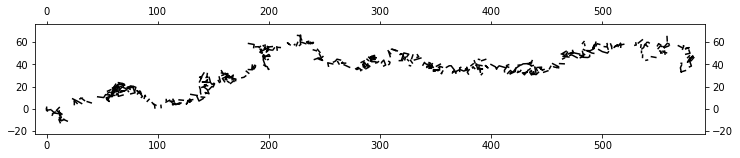

iteration: 50 of 39000, avg_loss: 2081.93, timeSinceStart: 35.42, Epoch: 1
iteration: 100 of 39000, avg_loss: 2033.16, timeSinceStart: 68.51, Epoch: 2
iteration: 150 of 39000, avg_loss: 1838.90, timeSinceStart: 102.00, Epoch: 3
iteration: 200 of 39000, avg_loss: 1612.39, timeSinceStart: 135.19, Epoch: 5
iteration: 250 of 39000, avg_loss: 1586.88, timeSinceStart: 168.69, Epoch: 6


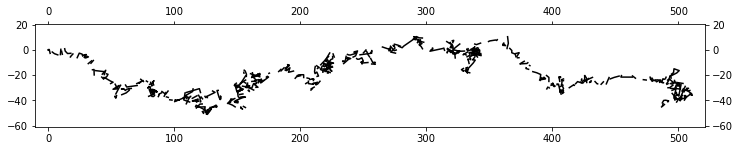

iteration: 300 of 39000, avg_loss: 1472.08, timeSinceStart: 203.91, Epoch: 7
iteration: 350 of 39000, avg_loss: 1434.19, timeSinceStart: 237.48, Epoch: 8
iteration: 400 of 39000, avg_loss: 1393.96, timeSinceStart: 271.01, Epoch: 10
iteration: 450 of 39000, avg_loss: 1206.72, timeSinceStart: 304.38, Epoch: 11
iteration: 500 of 39000, avg_loss: 1218.62, timeSinceStart: 337.74, Epoch: 12


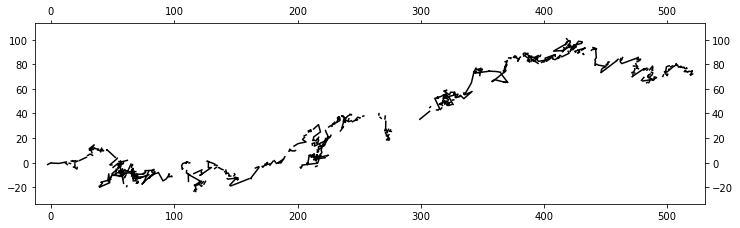

iteration: 550 of 39000, avg_loss: 1093.43, timeSinceStart: 372.88, Epoch: 14
iteration: 600 of 39000, avg_loss: 1048.62, timeSinceStart: 406.37, Epoch: 15
iteration: 650 of 39000, avg_loss: 812.41, timeSinceStart: 439.94, Epoch: 16
iteration: 700 of 39000, avg_loss: 730.85, timeSinceStart: 473.38, Epoch: 17
iteration: 750 of 39000, avg_loss: 738.14, timeSinceStart: 506.85, Epoch: 19


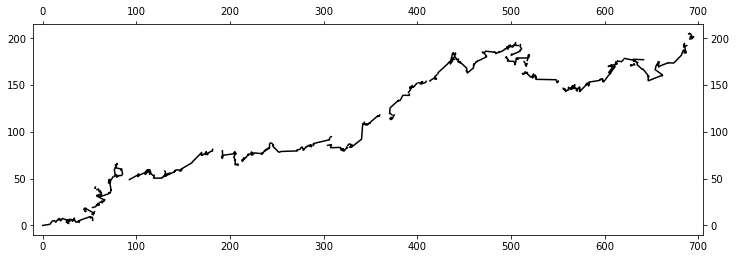

iteration: 800 of 39000, avg_loss: 706.97, timeSinceStart: 541.75, Epoch: 20
iteration: 850 of 39000, avg_loss: 619.99, timeSinceStart: 575.20, Epoch: 21
iteration: 900 of 39000, avg_loss: 685.84, timeSinceStart: 608.72, Epoch: 23
iteration: 950 of 39000, avg_loss: 564.50, timeSinceStart: 642.18, Epoch: 24
iteration: 1000 of 39000, avg_loss: 705.13, timeSinceStart: 675.88, Epoch: 25


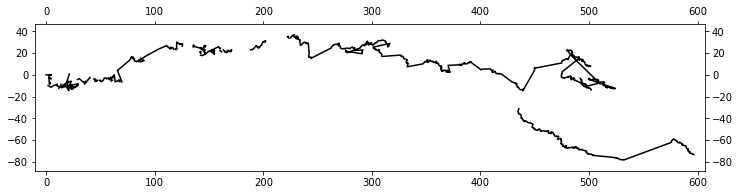

iteration: 1050 of 39000, avg_loss: 649.79, timeSinceStart: 710.65, Epoch: 26
iteration: 1100 of 39000, avg_loss: 492.48, timeSinceStart: 744.14, Epoch: 28
iteration: 1150 of 39000, avg_loss: 678.26, timeSinceStart: 777.51, Epoch: 29
iteration: 1200 of 39000, avg_loss: 576.56, timeSinceStart: 811.02, Epoch: 30
iteration: 1250 of 39000, avg_loss: 488.68, timeSinceStart: 844.48, Epoch: 32


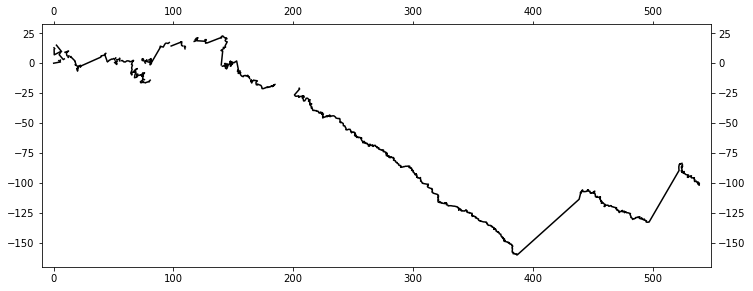

iteration: 1300 of 39000, avg_loss: 648.44, timeSinceStart: 879.36, Epoch: 33
iteration: 1350 of 39000, avg_loss: 602.32, timeSinceStart: 912.98, Epoch: 34
iteration: 1400 of 39000, avg_loss: 439.03, timeSinceStart: 946.44, Epoch: 35
iteration: 1450 of 39000, avg_loss: 435.46, timeSinceStart: 979.96, Epoch: 37
iteration: 1500 of 39000, avg_loss: 717.57, timeSinceStart: 1013.46, Epoch: 38


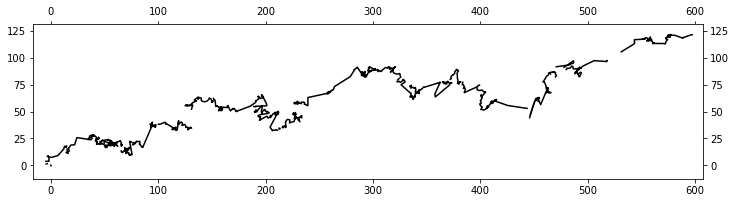

iteration: 1550 of 39000, avg_loss: 603.30, timeSinceStart: 1048.38, Epoch: 39
iteration: 1600 of 39000, avg_loss: 414.45, timeSinceStart: 1081.98, Epoch: 41
iteration: 1650 of 39000, avg_loss: 445.11, timeSinceStart: 1115.33, Epoch: 42
iteration: 1700 of 39000, avg_loss: 598.95, timeSinceStart: 1148.85, Epoch: 43
iteration: 1750 of 39000, avg_loss: 688.04, timeSinceStart: 1182.49, Epoch: 44


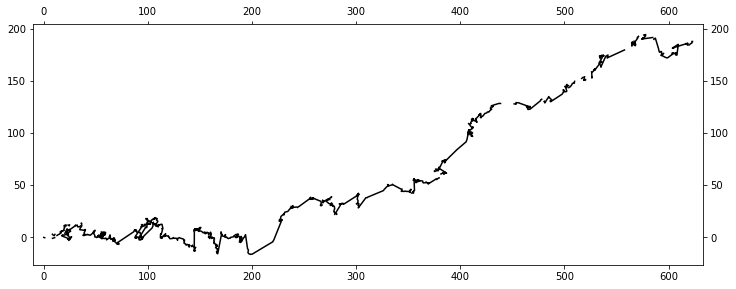

iteration: 1800 of 39000, avg_loss: 458.98, timeSinceStart: 1217.32, Epoch: 46
iteration: 1850 of 39000, avg_loss: 387.80, timeSinceStart: 1250.88, Epoch: 47
iteration: 1900 of 39000, avg_loss: 706.39, timeSinceStart: 1284.62, Epoch: 48
iteration: 1950 of 39000, avg_loss: 727.73, timeSinceStart: 1318.27, Epoch: 50
iteration: 2000 of 39000, avg_loss: 478.00, timeSinceStart: 1351.78, Epoch: 51


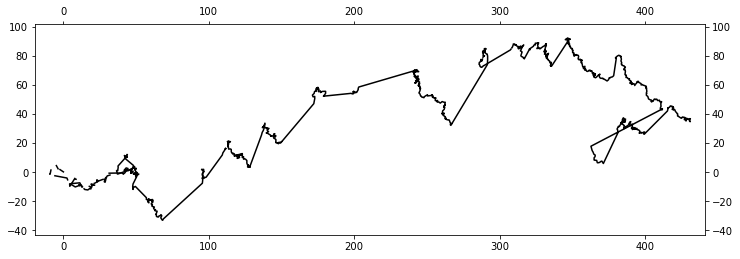

iteration: 2050 of 39000, avg_loss: 341.63, timeSinceStart: 1386.63, Epoch: 52
iteration: 2100 of 39000, avg_loss: 486.74, timeSinceStart: 1420.06, Epoch: 53
iteration: 2150 of 39000, avg_loss: 756.80, timeSinceStart: 1453.52, Epoch: 55
iteration: 2200 of 39000, avg_loss: 717.71, timeSinceStart: 1487.03, Epoch: 56
iteration: 2250 of 39000, avg_loss: 695.95, timeSinceStart: 1520.67, Epoch: 57


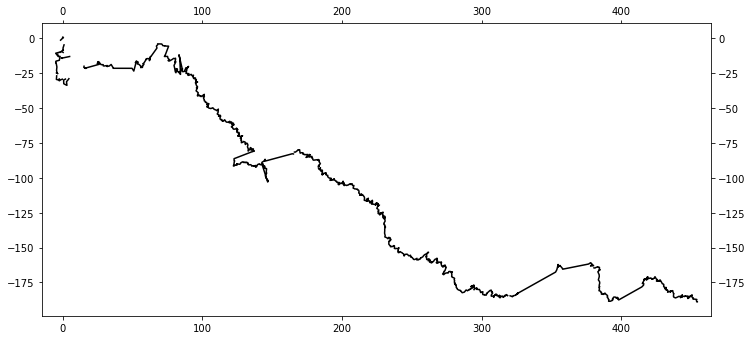

iteration: 2300 of 39000, avg_loss: 673.81, timeSinceStart: 1555.51, Epoch: 58
iteration: 2350 of 39000, avg_loss: 657.45, timeSinceStart: 1588.98, Epoch: 60
iteration: 2400 of 39000, avg_loss: 500.48, timeSinceStart: 1622.39, Epoch: 61
iteration: 2450 of 39000, avg_loss: 337.23, timeSinceStart: 1655.82, Epoch: 62
iteration: 2500 of 39000, avg_loss: 646.69, timeSinceStart: 1689.23, Epoch: 64


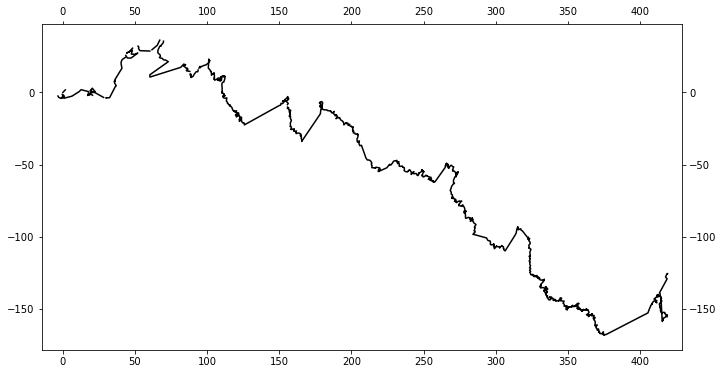

iteration: 2550 of 39000, avg_loss: 665.50, timeSinceStart: 1724.16, Epoch: 65
iteration: 2600 of 39000, avg_loss: 648.59, timeSinceStart: 1757.46, Epoch: 66
iteration: 2650 of 39000, avg_loss: 634.19, timeSinceStart: 1790.89, Epoch: 67
iteration: 2700 of 39000, avg_loss: 622.43, timeSinceStart: 1824.72, Epoch: 69
iteration: 2750 of 39000, avg_loss: 607.51, timeSinceStart: 1858.14, Epoch: 70


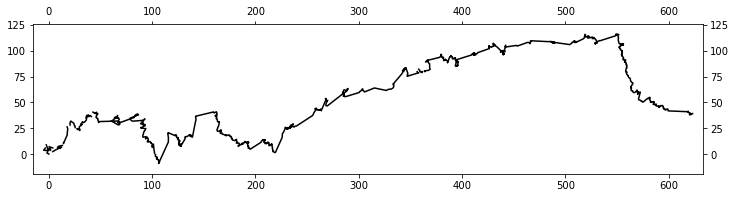

iteration: 2800 of 39000, avg_loss: 598.30, timeSinceStart: 1893.04, Epoch: 71
iteration: 2850 of 39000, avg_loss: 585.79, timeSinceStart: 1926.78, Epoch: 73
iteration: 2900 of 39000, avg_loss: 573.97, timeSinceStart: 1960.27, Epoch: 74
iteration: 2950 of 39000, avg_loss: 555.91, timeSinceStart: 1993.79, Epoch: 75
iteration: 3000 of 39000, avg_loss: 549.18, timeSinceStart: 2027.29, Epoch: 76


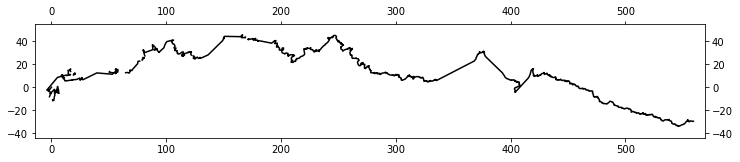

iteration: 3050 of 39000, avg_loss: 530.07, timeSinceStart: 2062.16, Epoch: 78
iteration: 3100 of 39000, avg_loss: 548.63, timeSinceStart: 2095.62, Epoch: 79
iteration: 3150 of 39000, avg_loss: 586.87, timeSinceStart: 2129.06, Epoch: 80
iteration: 3200 of 39000, avg_loss: 587.35, timeSinceStart: 2162.61, Epoch: 82
iteration: 3250 of 39000, avg_loss: 545.27, timeSinceStart: 2196.19, Epoch: 83


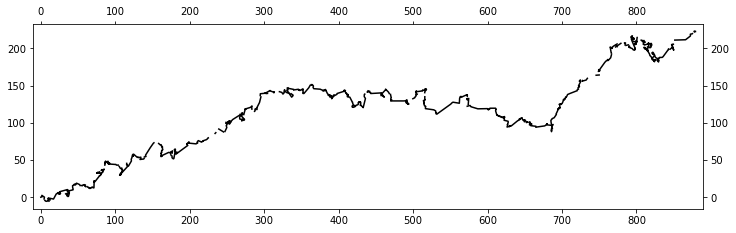

iteration: 3300 of 39000, avg_loss: 587.83, timeSinceStart: 2231.38, Epoch: 84
iteration: 3350 of 39000, avg_loss: 526.87, timeSinceStart: 2264.82, Epoch: 85
iteration: 3400 of 39000, avg_loss: 551.28, timeSinceStart: 2298.32, Epoch: 87
iteration: 3450 of 39000, avg_loss: 479.25, timeSinceStart: 2331.91, Epoch: 88
iteration: 3500 of 39000, avg_loss: 512.31, timeSinceStart: 2365.23, Epoch: 89


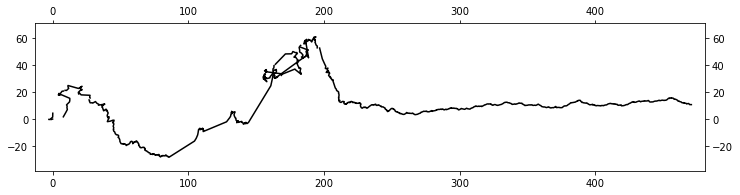

iteration: 3550 of 39000, avg_loss: 430.82, timeSinceStart: 2400.24, Epoch: 91
iteration: 3600 of 39000, avg_loss: 496.31, timeSinceStart: 2433.83, Epoch: 92
iteration: 3650 of 39000, avg_loss: 388.76, timeSinceStart: 2467.37, Epoch: 93
iteration: 3700 of 39000, avg_loss: 400.92, timeSinceStart: 2500.85, Epoch: 94
iteration: 3750 of 39000, avg_loss: 380.23, timeSinceStart: 2534.28, Epoch: 96


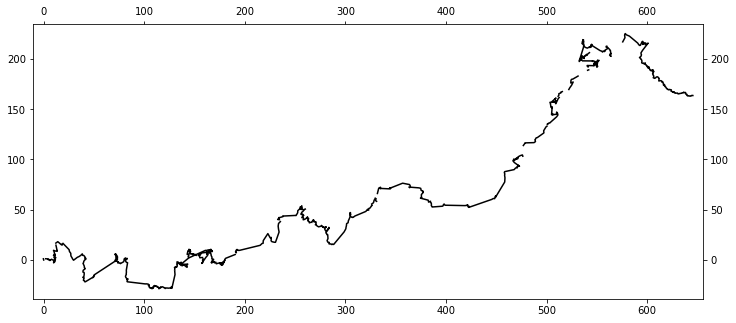

iteration: 3800 of 39000, avg_loss: 346.11, timeSinceStart: 2569.11, Epoch: 97
iteration: 3850 of 39000, avg_loss: 366.40, timeSinceStart: 2602.62, Epoch: 98
iteration: 3900 of 39000, avg_loss: 351.41, timeSinceStart: 2636.13, Epoch: 100
iteration: 3950 of 39000, avg_loss: 320.49, timeSinceStart: 2669.62, Epoch: 101
iteration: 4000 of 39000, avg_loss: 357.33, timeSinceStart: 2703.18, Epoch: 102


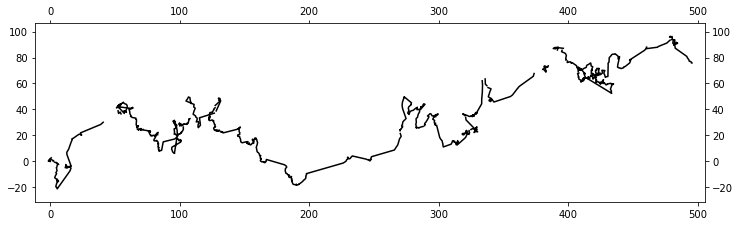

iteration: 4050 of 39000, avg_loss: 349.23, timeSinceStart: 2738.02, Epoch: 103
iteration: 4100 of 39000, avg_loss: 268.52, timeSinceStart: 2771.46, Epoch: 105
iteration: 4150 of 39000, avg_loss: 457.49, timeSinceStart: 2804.82, Epoch: 106
iteration: 4200 of 39000, avg_loss: 506.05, timeSinceStart: 2838.53, Epoch: 107
iteration: 4250 of 39000, avg_loss: 281.85, timeSinceStart: 2872.37, Epoch: 108


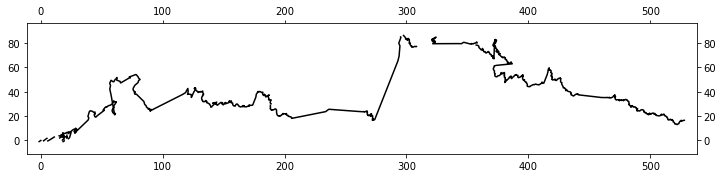

iteration: 4300 of 39000, avg_loss: 225.95, timeSinceStart: 2907.12, Epoch: 110
iteration: 4350 of 39000, avg_loss: 517.52, timeSinceStart: 2940.78, Epoch: 111
iteration: 4400 of 39000, avg_loss: 470.38, timeSinceStart: 2974.38, Epoch: 112
iteration: 4450 of 39000, avg_loss: 423.41, timeSinceStart: 3007.83, Epoch: 114
iteration: 4500 of 39000, avg_loss: 375.22, timeSinceStart: 3041.52, Epoch: 115


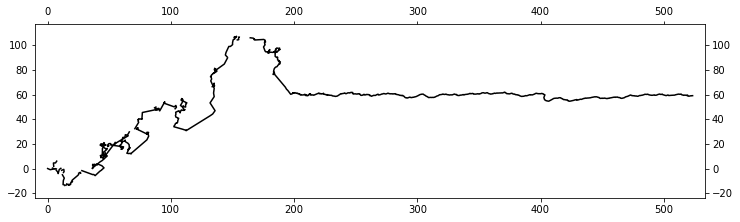

iteration: 4550 of 39000, avg_loss: 351.50, timeSinceStart: 3076.36, Epoch: 116
iteration: 4600 of 39000, avg_loss: 453.15, timeSinceStart: 3109.81, Epoch: 117
iteration: 4650 of 39000, avg_loss: 405.16, timeSinceStart: 3143.21, Epoch: 119
iteration: 4700 of 39000, avg_loss: 347.41, timeSinceStart: 3176.68, Epoch: 120
iteration: 4750 of 39000, avg_loss: 278.08, timeSinceStart: 3210.32, Epoch: 121


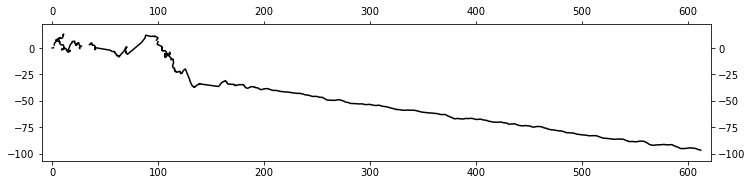

iteration: 4800 of 39000, avg_loss: 202.36, timeSinceStart: 3245.21, Epoch: 123
iteration: 4850 of 39000, avg_loss: 200.67, timeSinceStart: 3278.60, Epoch: 124
iteration: 4900 of 39000, avg_loss: 301.57, timeSinceStart: 3312.17, Epoch: 125
iteration: 4950 of 39000, avg_loss: 368.26, timeSinceStart: 3345.65, Epoch: 126
iteration: 5000 of 39000, avg_loss: 230.90, timeSinceStart: 3379.48, Epoch: 128


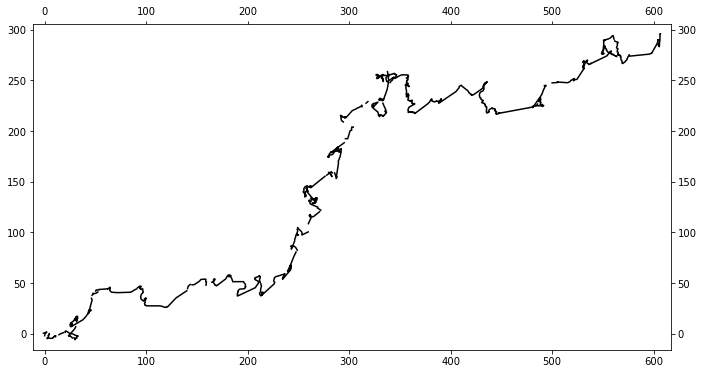

iteration: 5050 of 39000, avg_loss: 299.41, timeSinceStart: 3414.45, Epoch: 129
iteration: 5100 of 39000, avg_loss: 128.54, timeSinceStart: 3447.90, Epoch: 130
iteration: 5150 of 39000, avg_loss: 197.76, timeSinceStart: 3481.49, Epoch: 132
iteration: 5200 of 39000, avg_loss: 185.56, timeSinceStart: 3514.93, Epoch: 133
iteration: 5250 of 39000, avg_loss: 129.64, timeSinceStart: 3548.43, Epoch: 134


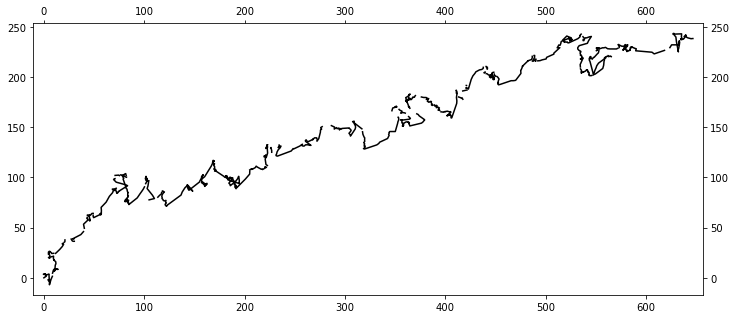

iteration: 5300 of 39000, avg_loss: 327.70, timeSinceStart: 3583.41, Epoch: 135
iteration: 5350 of 39000, avg_loss: 96.69, timeSinceStart: 3617.11, Epoch: 137
iteration: 5400 of 39000, avg_loss: 151.60, timeSinceStart: 3650.66, Epoch: 138
iteration: 5450 of 39000, avg_loss: 101.09, timeSinceStart: 3684.42, Epoch: 139
iteration: 5500 of 39000, avg_loss: 220.68, timeSinceStart: 3718.03, Epoch: 141


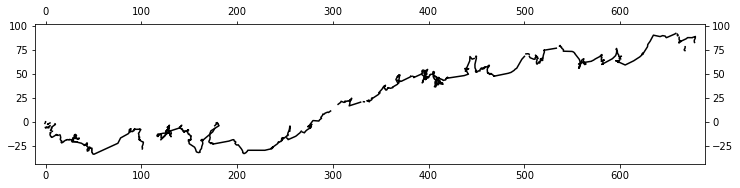

iteration: 5550 of 39000, avg_loss: 228.90, timeSinceStart: 3752.99, Epoch: 142
iteration: 5600 of 39000, avg_loss: 12.46, timeSinceStart: 3786.48, Epoch: 143
iteration: 5650 of 39000, avg_loss: 44.89, timeSinceStart: 3820.09, Epoch: 144
iteration: 5700 of 39000, avg_loss: 34.23, timeSinceStart: 3853.62, Epoch: 146
iteration: 5750 of 39000, avg_loss: 98.96, timeSinceStart: 3887.17, Epoch: 147


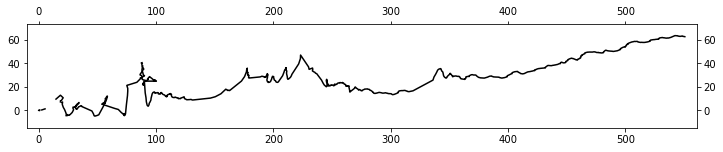

iteration: 5800 of 39000, avg_loss: 105.81, timeSinceStart: 3921.88, Epoch: 148
iteration: 5850 of 39000, avg_loss: 236.57, timeSinceStart: 3955.67, Epoch: 150
iteration: 5900 of 39000, avg_loss: 446.22, timeSinceStart: 3989.24, Epoch: 151
iteration: 5950 of 39000, avg_loss: 240.70, timeSinceStart: 4022.86, Epoch: 152
iteration: 6000 of 39000, avg_loss: 136.20, timeSinceStart: 4056.49, Epoch: 153


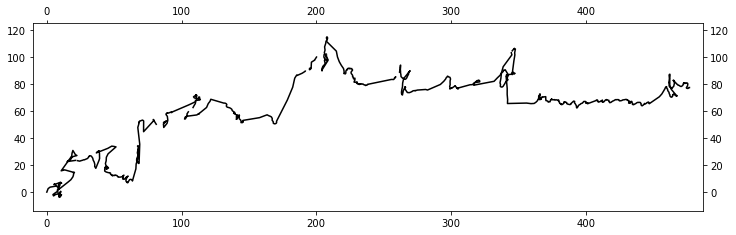

iteration: 6050 of 39000, avg_loss: 87.78, timeSinceStart: 4091.44, Epoch: 155
iteration: 6100 of 39000, avg_loss: 360.64, timeSinceStart: 4124.99, Epoch: 156
iteration: 6150 of 39000, avg_loss: 192.54, timeSinceStart: 4158.38, Epoch: 157
iteration: 6200 of 39000, avg_loss: 104.96, timeSinceStart: 4191.82, Epoch: 158
iteration: 6250 of 39000, avg_loss: 48.90, timeSinceStart: 4225.32, Epoch: 160


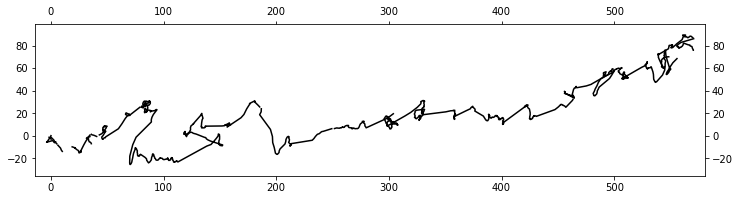

iteration: 6300 of 39000, avg_loss: -22.61, timeSinceStart: 4260.10, Epoch: 161
iteration: 6350 of 39000, avg_loss: 199.80, timeSinceStart: 4293.67, Epoch: 162
iteration: 6400 of 39000, avg_loss: 28.80, timeSinceStart: 4327.21, Epoch: 164
iteration: 6450 of 39000, avg_loss: 130.31, timeSinceStart: 4360.84, Epoch: 165
iteration: 6500 of 39000, avg_loss: -41.48, timeSinceStart: 4394.34, Epoch: 166


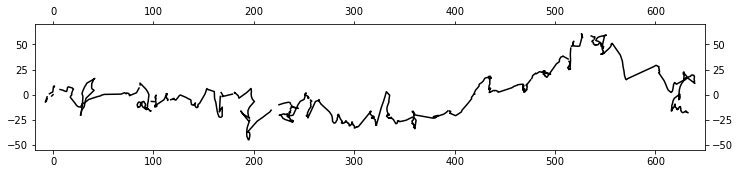

iteration: 6550 of 39000, avg_loss: 195.73, timeSinceStart: 4429.28, Epoch: 167
iteration: 6600 of 39000, avg_loss: -80.84, timeSinceStart: 4462.93, Epoch: 169
iteration: 6650 of 39000, avg_loss: -148.14, timeSinceStart: 4496.54, Epoch: 170
iteration: 6700 of 39000, avg_loss: -23.21, timeSinceStart: 4529.83, Epoch: 171
iteration: 6750 of 39000, avg_loss: -46.40, timeSinceStart: 4563.24, Epoch: 173


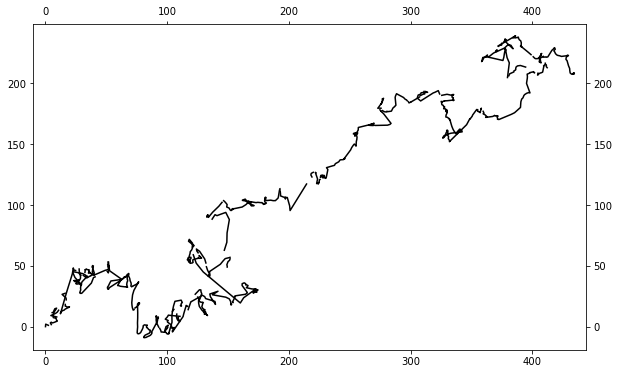

iteration: 6800 of 39000, avg_loss: -107.72, timeSinceStart: 4597.92, Epoch: 174
iteration: 6850 of 39000, avg_loss: 41.15, timeSinceStart: 4631.12, Epoch: 175
iteration: 6900 of 39000, avg_loss: 102.26, timeSinceStart: 4664.50, Epoch: 176
iteration: 6950 of 39000, avg_loss: 67.63, timeSinceStart: 4697.81, Epoch: 178
iteration: 7000 of 39000, avg_loss: 6.30, timeSinceStart: 4731.20, Epoch: 179


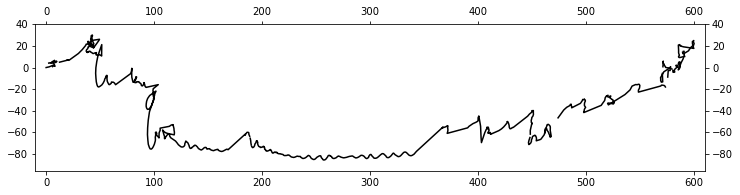

iteration: 7050 of 39000, avg_loss: -114.25, timeSinceStart: 4765.72, Epoch: 180
iteration: 7100 of 39000, avg_loss: 64.41, timeSinceStart: 4799.08, Epoch: 182
iteration: 7150 of 39000, avg_loss: -123.18, timeSinceStart: 4832.36, Epoch: 183
iteration: 7200 of 39000, avg_loss: -189.84, timeSinceStart: 4865.84, Epoch: 184
iteration: 7250 of 39000, avg_loss: -206.34, timeSinceStart: 4899.24, Epoch: 185


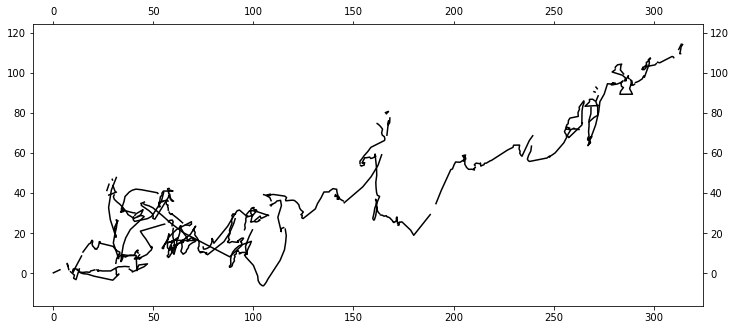

iteration: 7300 of 39000, avg_loss: -63.27, timeSinceStart: 4934.02, Epoch: 187
iteration: 7350 of 39000, avg_loss: -50.27, timeSinceStart: 4967.40, Epoch: 188
iteration: 7400 of 39000, avg_loss: 144.86, timeSinceStart: 5000.65, Epoch: 189
iteration: 7450 of 39000, avg_loss: -95.66, timeSinceStart: 5034.07, Epoch: 191
iteration: 7500 of 39000, avg_loss: -33.89, timeSinceStart: 5067.50, Epoch: 192


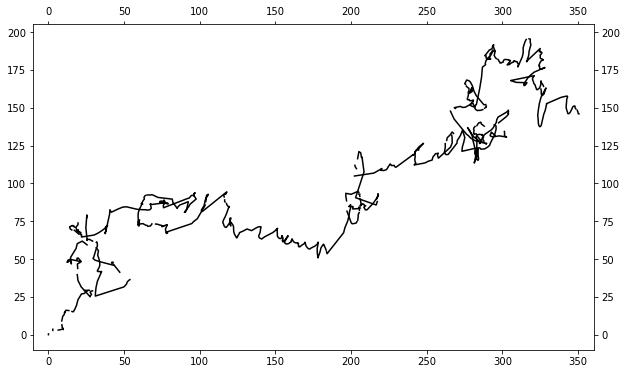

iteration: 7550 of 39000, avg_loss: -136.57, timeSinceStart: 5102.20, Epoch: 193
iteration: 7600 of 39000, avg_loss: 80.96, timeSinceStart: 5135.54, Epoch: 194
iteration: 7650 of 39000, avg_loss: -33.64, timeSinceStart: 5168.96, Epoch: 196
iteration: 7700 of 39000, avg_loss: -79.48, timeSinceStart: 5202.29, Epoch: 197
iteration: 7750 of 39000, avg_loss: -118.30, timeSinceStart: 5235.70, Epoch: 198


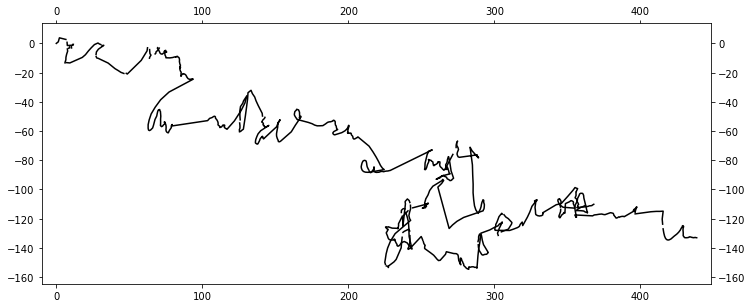

iteration: 7800 of 39000, avg_loss: -178.13, timeSinceStart: 5270.32, Epoch: 200
iteration: 7850 of 39000, avg_loss: -279.89, timeSinceStart: 5303.55, Epoch: 201
iteration: 7900 of 39000, avg_loss: -298.03, timeSinceStart: 5336.89, Epoch: 202
iteration: 7950 of 39000, avg_loss: -269.42, timeSinceStart: 5370.22, Epoch: 203
iteration: 8000 of 39000, avg_loss: -202.81, timeSinceStart: 5403.54, Epoch: 205


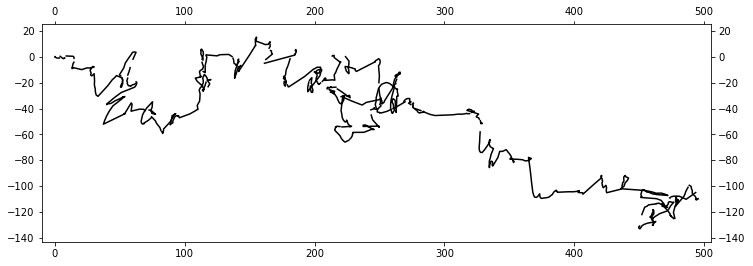

iteration: 8050 of 39000, avg_loss: -237.32, timeSinceStart: 5438.28, Epoch: 206
iteration: 8100 of 39000, avg_loss: -133.66, timeSinceStart: 5471.67, Epoch: 207
iteration: 8150 of 39000, avg_loss: -330.23, timeSinceStart: 5505.02, Epoch: 208
iteration: 8200 of 39000, avg_loss: -184.26, timeSinceStart: 5538.38, Epoch: 210
iteration: 8250 of 39000, avg_loss: -330.85, timeSinceStart: 5571.64, Epoch: 211


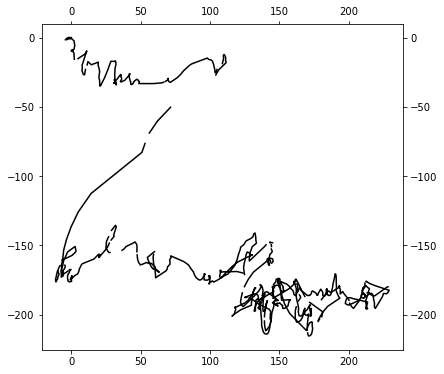

iteration: 8300 of 39000, avg_loss: 33.27, timeSinceStart: 5606.40, Epoch: 212
iteration: 8350 of 39000, avg_loss: -55.32, timeSinceStart: 5639.88, Epoch: 214
iteration: 8400 of 39000, avg_loss: -246.99, timeSinceStart: 5673.26, Epoch: 215
iteration: 8450 of 39000, avg_loss: -217.62, timeSinceStart: 5706.52, Epoch: 216
iteration: 8500 of 39000, avg_loss: -228.92, timeSinceStart: 5739.95, Epoch: 217


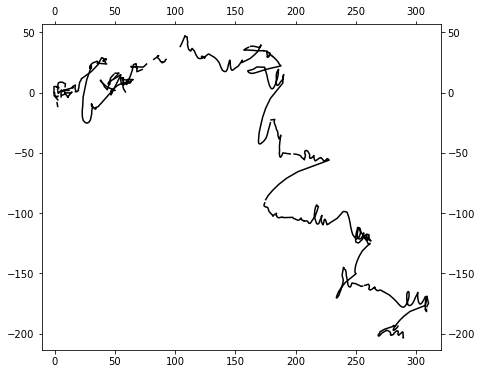

iteration: 8550 of 39000, avg_loss: -62.58, timeSinceStart: 5774.54, Epoch: 219
iteration: 8600 of 39000, avg_loss: -183.49, timeSinceStart: 5807.95, Epoch: 220
iteration: 8650 of 39000, avg_loss: -24.66, timeSinceStart: 5841.33, Epoch: 221
iteration: 8700 of 39000, avg_loss: -269.50, timeSinceStart: 5874.80, Epoch: 223
iteration: 8750 of 39000, avg_loss: -317.34, timeSinceStart: 5908.12, Epoch: 224


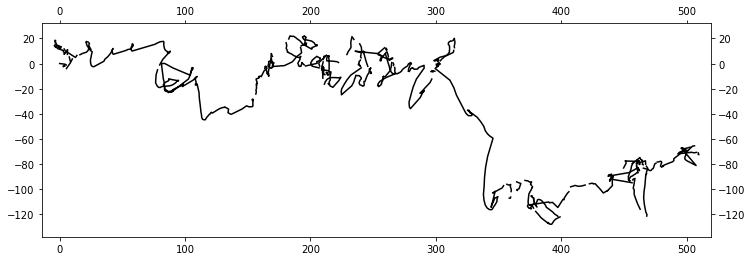

iteration: 8800 of 39000, avg_loss: -110.39, timeSinceStart: 5942.86, Epoch: 225
iteration: 8850 of 39000, avg_loss: -341.78, timeSinceStart: 5976.31, Epoch: 226
iteration: 8900 of 39000, avg_loss: -198.04, timeSinceStart: 6009.76, Epoch: 228
iteration: 8950 of 39000, avg_loss: -338.66, timeSinceStart: 6043.15, Epoch: 229
iteration: 9000 of 39000, avg_loss: -59.83, timeSinceStart: 6076.47, Epoch: 230


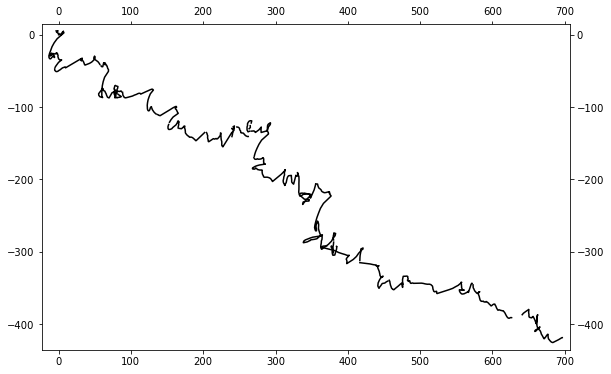

iteration: 9050 of 39000, avg_loss: -192.38, timeSinceStart: 6111.16, Epoch: 232
iteration: 9100 of 39000, avg_loss: -342.81, timeSinceStart: 6144.56, Epoch: 233
iteration: 9150 of 39000, avg_loss: -433.64, timeSinceStart: 6177.91, Epoch: 234
iteration: 9200 of 39000, avg_loss: -150.76, timeSinceStart: 6211.24, Epoch: 235
iteration: 9250 of 39000, avg_loss: -422.10, timeSinceStart: 6244.58, Epoch: 237


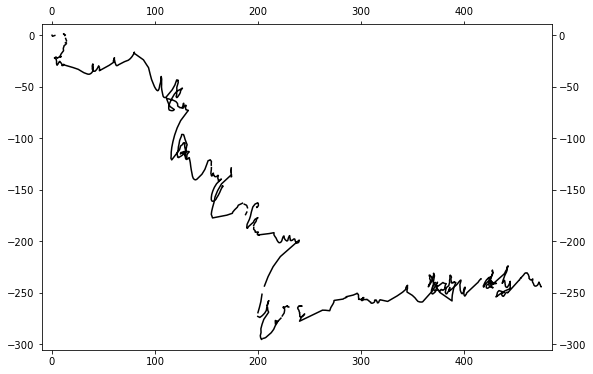

iteration: 9300 of 39000, avg_loss: -68.48, timeSinceStart: 6279.32, Epoch: 238
iteration: 9350 of 39000, avg_loss: -320.48, timeSinceStart: 6312.67, Epoch: 239
iteration: 9400 of 39000, avg_loss: -446.92, timeSinceStart: 6346.00, Epoch: 241
iteration: 9450 of 39000, avg_loss: -472.01, timeSinceStart: 6379.49, Epoch: 242
iteration: 9500 of 39000, avg_loss: -190.05, timeSinceStart: 6412.85, Epoch: 243


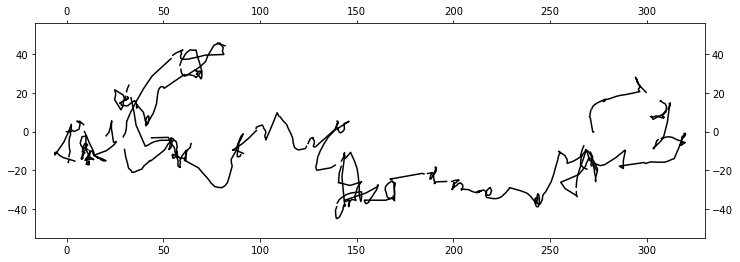

iteration: 9550 of 39000, avg_loss: -462.65, timeSinceStart: 6447.47, Epoch: 244
iteration: 9600 of 39000, avg_loss: -181.00, timeSinceStart: 6480.82, Epoch: 246
iteration: 9650 of 39000, avg_loss: -296.00, timeSinceStart: 6514.05, Epoch: 247
iteration: 9700 of 39000, avg_loss: -458.06, timeSinceStart: 6547.37, Epoch: 248
iteration: 9750 of 39000, avg_loss: -521.07, timeSinceStart: 6580.66, Epoch: 250


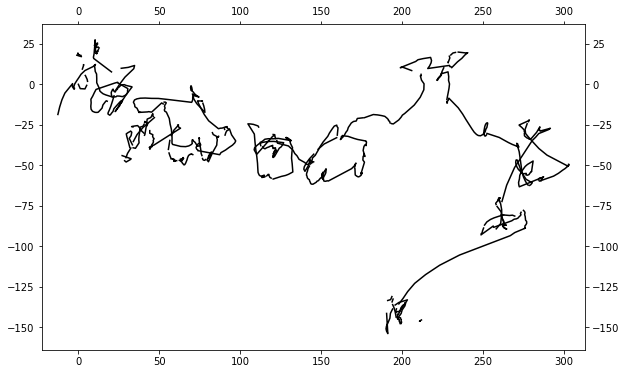

iteration: 9800 of 39000, avg_loss: -364.77, timeSinceStart: 6615.31, Epoch: 251
iteration: 9850 of 39000, avg_loss: -362.42, timeSinceStart: 6648.48, Epoch: 252
iteration: 9900 of 39000, avg_loss: -213.82, timeSinceStart: 6681.89, Epoch: 253
iteration: 9950 of 39000, avg_loss: -474.54, timeSinceStart: 6715.24, Epoch: 255
iteration: 10000 of 39000, avg_loss: -550.47, timeSinceStart: 6748.57, Epoch: 256


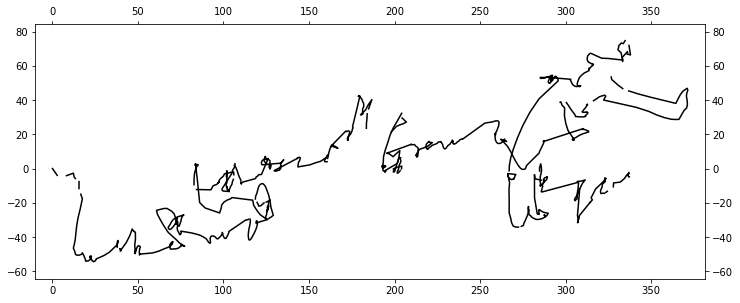

iteration: 10050 of 39000, avg_loss: -632.16, timeSinceStart: 6783.27, Epoch: 257
iteration: 10100 of 39000, avg_loss: -400.05, timeSinceStart: 6816.66, Epoch: 258
iteration: 10150 of 39000, avg_loss: -379.77, timeSinceStart: 6850.10, Epoch: 260


In [ ]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
